In [1]:
MAIN_OUTPUT_DIR = "NFS-2023-TE"
CSV_DIR = "datasets"

## Binary Classificaiton

### Feature Selection

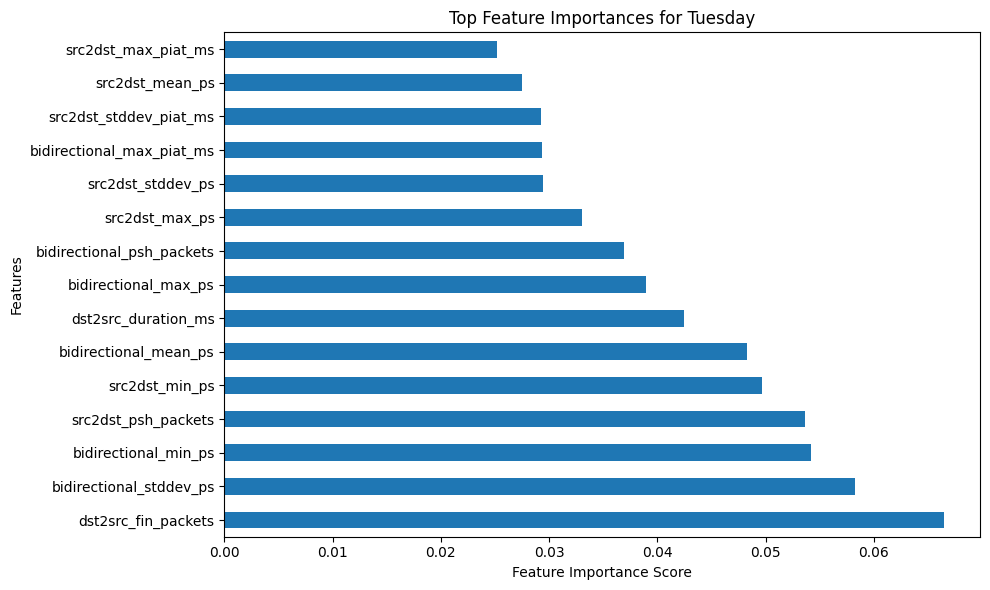

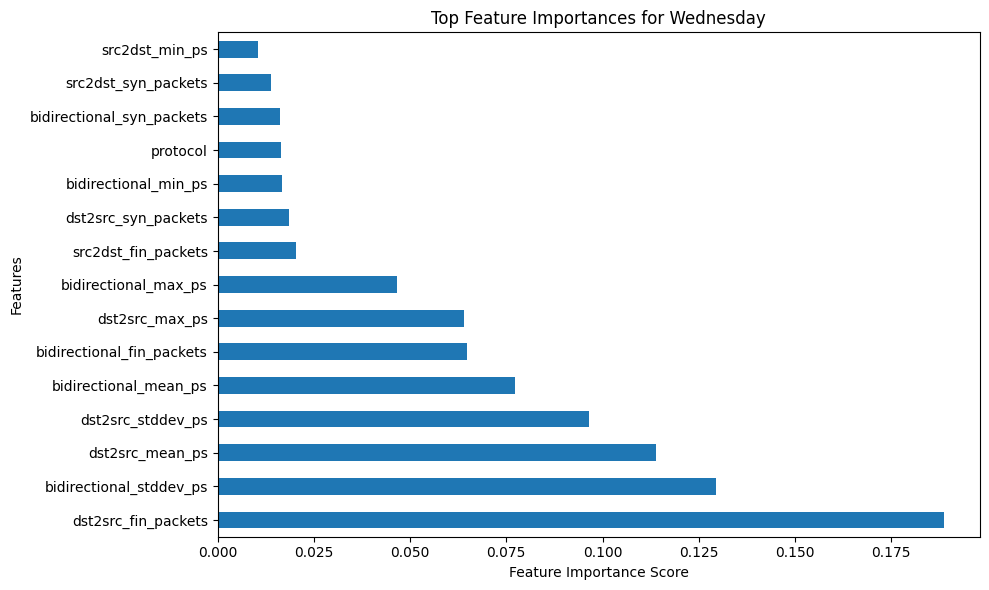

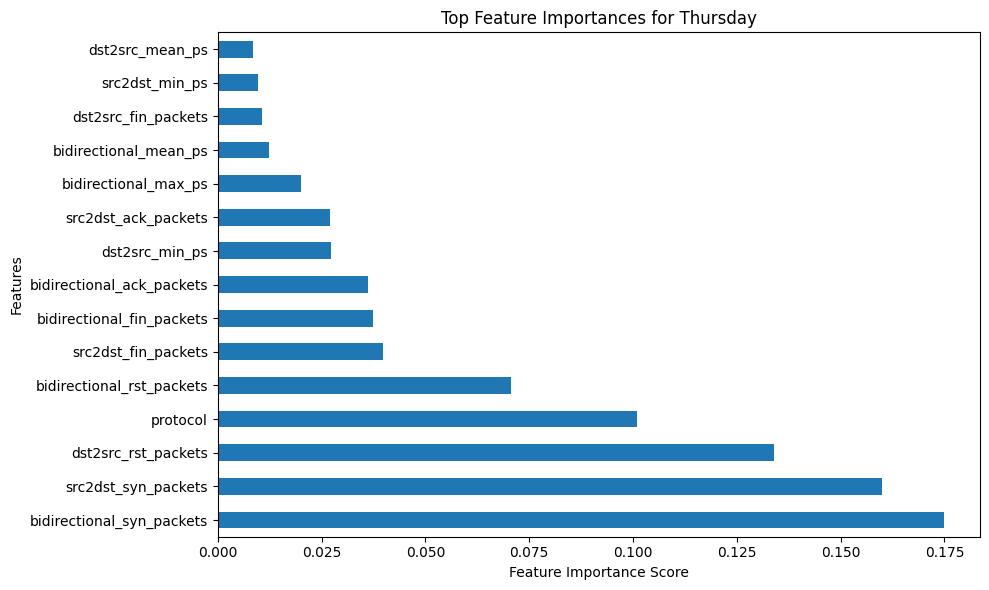

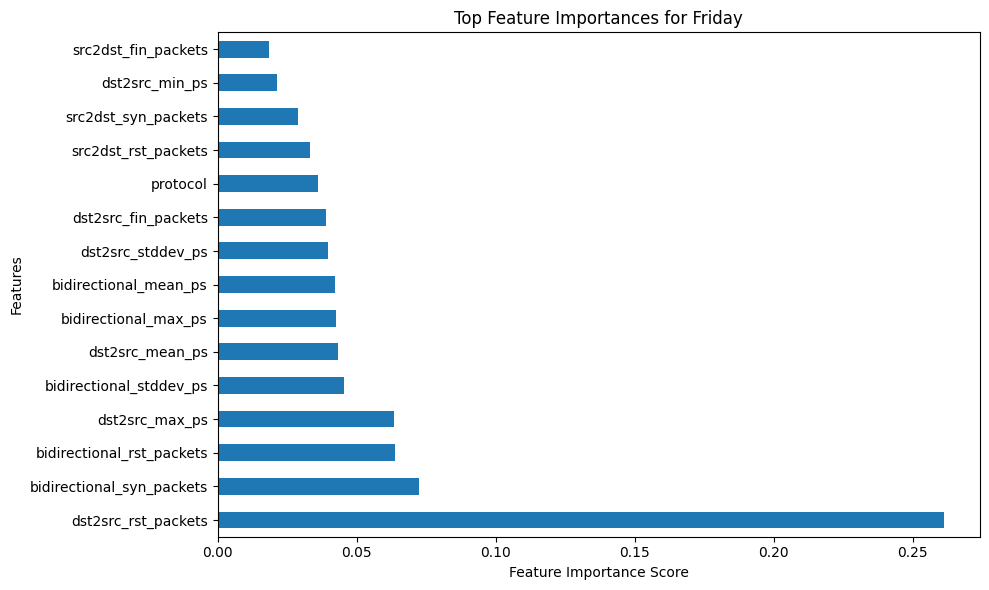

Top features for Tuesday:
['dst2src_fin_packets', 'bidirectional_stddev_ps', 'bidirectional_min_ps', 'src2dst_psh_packets', 'src2dst_min_ps', 'bidirectional_mean_ps', 'dst2src_duration_ms', 'bidirectional_max_ps', 'bidirectional_psh_packets', 'src2dst_max_ps', 'src2dst_stddev_ps', 'bidirectional_max_piat_ms', 'src2dst_stddev_piat_ms', 'src2dst_mean_ps', 'src2dst_max_piat_ms']

Top features for Wednesday:
['dst2src_fin_packets', 'bidirectional_stddev_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps', 'bidirectional_mean_ps', 'bidirectional_fin_packets', 'dst2src_max_ps', 'bidirectional_max_ps', 'src2dst_fin_packets', 'dst2src_syn_packets', 'bidirectional_min_ps', 'protocol', 'bidirectional_syn_packets', 'src2dst_syn_packets', 'src2dst_min_ps']

Top features for Thursday:
['bidirectional_syn_packets', 'src2dst_syn_packets', 'dst2src_rst_packets', 'protocol', 'bidirectional_rst_packets', 'src2dst_fin_packets', 'bidirectional_fin_packets', 'bidirectional_ack_packets', 'dst2src_min_ps', 'src2dst_

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import json

# GLOBAL VARIABLES
TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

# Define the path to the CSV files and the output directory
PATH= os.path.join(MAIN_OUTPUT_DIR, CSV_DIR)
output_path = os.path.join(MAIN_OUTPUT_DIR, 'feat_sel/binary-class')

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to preprocess data and return top features
def process_data(day):
    file_path = os.path.join(PATH, f"{day}.csv")
    data = pd.read_csv(file_path)
    
    # ... [Data preprocessing steps] ...
    # data.replace([np.inf, -np.inf], np.nan, inplace=True)
    # data.dropna(inplace=True)
    data['binary_label'] = data['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    
    # print(data.columns)
    
    drop_columns = ['id', 'src_ip', 'src_mac', 'src_oui', 'dst_ip', 'dst_mac', 'dst_oui', 
                    # 'splt_direction', 'splt_ps', 'splt_piat_ms',
                    'src_port', 'dst_port', 
                    # 'protocol',
                    'bidirectional_first_seen_ms', 'bidirectional_last_seen_ms',
                    'src2dst_first_seen_ms', 'src2dst_last_seen_ms',
                    'dst2src_first_seen_ms', 'dst2src_last_seen_ms',
                    'expiration_id', 'ip_version', 'vlan_id',   
                    'label']
    data.drop(columns=drop_columns, inplace=True)
    
    X = data.drop('binary_label', axis=1)
    y = data['binary_label']

    # Build the model
    model = ExtraTreesClassifier()
    model.fit(X, y)
    
    # Get feature importances
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    
    # Select top N features
    top_features = feat_importances.nlargest(15).index.tolist()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    feat_importances.nlargest(15).plot(kind='barh')
    plt.title(f'Top Feature Importances for {day}')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"{day}_feature_importances.png"))  # Save the figure
    # plt.close()  # Close the plot to prevent it from displaying inline if using a notebook
    plt.show()
    
    return top_features

# Dictionary to store top features for each day
top_features_per_day = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    top_features_per_day[day] = process_data(day)

# Print out the top features for each day
for day, features in top_features_per_day.items():
    print(f"Top features for {day}:\n{features}\n")

json_file_path = os.path.join(output_path, 'top_features_per_day.json')
with open(json_file_path, 'w') as json_file:
    json.dump(top_features_per_day, json_file, indent=4)

print(f"Top features for each day have been saved to {json_file_path}")

### Classification

In [3]:
import json
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Initialize a dictionary to store the metrics for each model
model_metrics = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    file_path = os.path.join(PATH, f"{day}.csv")
    data = pd.read_csv(file_path)
    
    # Preprocessing steps identical to the feature selection stage...
    # data.replace([np.inf, -np.inf], np.nan, inplace=True)
    # data.dropna(inplace=True)
    data['binary_label'] = data['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    X = data[top_features_per_day[day]]
    y = data['binary_label']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Initialize classifiers
    classifiers = {
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'NaiveBayes': GaussianNB()
    }
    
    # Train and evaluate each classifier
    for model_name, model in classifiers.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute the metrics
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        
        # Store metrics
        if day not in model_metrics:
            model_metrics[day] = {}
        model_metrics[day][model_name] = {
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        }

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame.from_dict({(i, j): model_metrics[i][j]
                                     for i in model_metrics.keys()
                                     for j in model_metrics[i].keys()},
                                    orient='index')

# Display the DataFrame
print(metrics_df)

# Specify the path for the JSON file where the metrics will be stored
metrics_json_path = os.path.join(output_path, 'model_performance_metrics.json')

# Convert the DataFrame into a JSON string and save it to a file
metrics_df.to_json(metrics_json_path, orient='split', indent=4)

# print(f"Model performance metrics have been saved to {metrics_json_path}")

                        Precision    Recall  Accuracy  F1 Score   ROC AUC
Tuesday   DecisionTree   0.998478  0.999391  0.999950  0.998934  0.999677
          RandomForest   0.999087  0.999695  0.999971  0.999391  0.999837
          NaiveBayes     0.055769  0.999086  0.603808  0.105641  0.796707
Wednesday DecisionTree   0.999369  0.999178  0.999707  0.999274  0.999509
          RandomForest   0.999522  0.999293  0.999761  0.999407  0.999586
          NaiveBayes     0.864749  0.952102  0.960339  0.906325  0.957260
Thursday  DecisionTree   0.983588  0.899925  0.983046  0.939899  0.948666
          RandomForest   0.984192  0.900019  0.983142  0.940225  0.948761
          NaiveBayes     0.477772  0.987316  0.839154  0.643937  0.900437
Friday    DecisionTree   0.999247  0.999247  0.999502  0.999247  0.999437
          RandomForest   0.999312  0.999247  0.999523  0.999279  0.999453
          NaiveBayes     0.854009  0.987666  0.940037  0.915987  0.952070


## Multi-class Classification

### Feature Selection

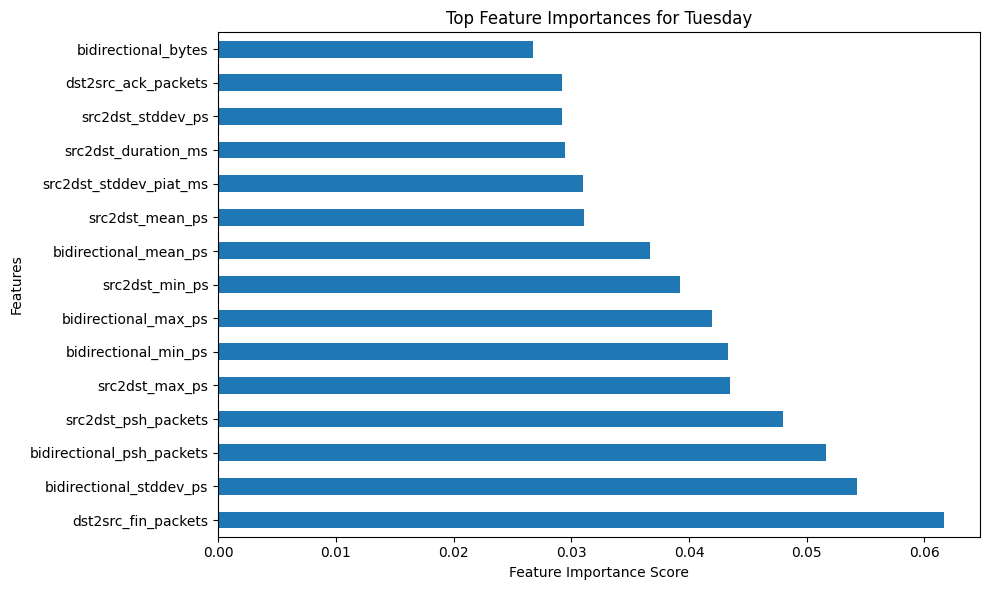

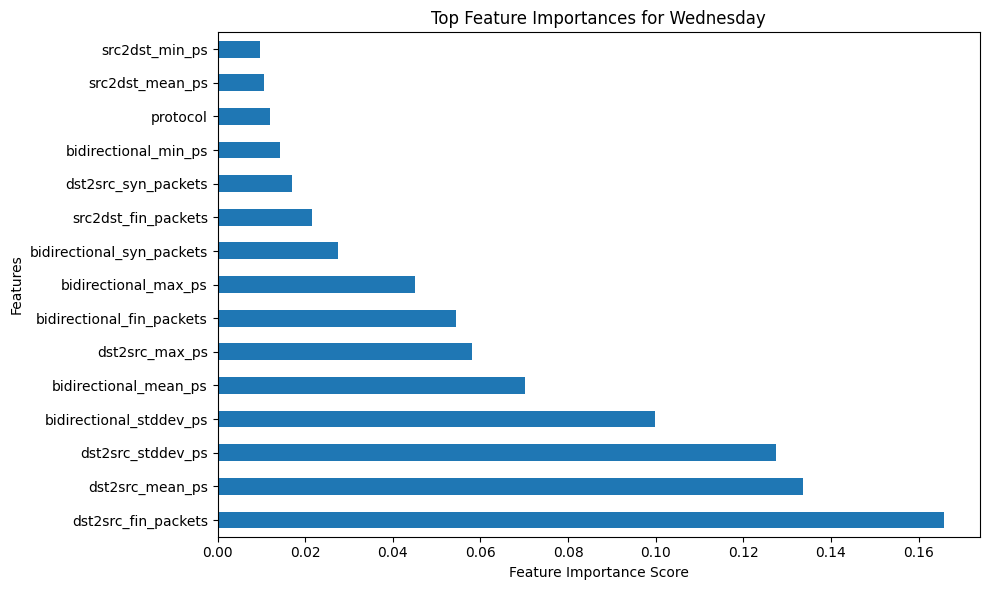

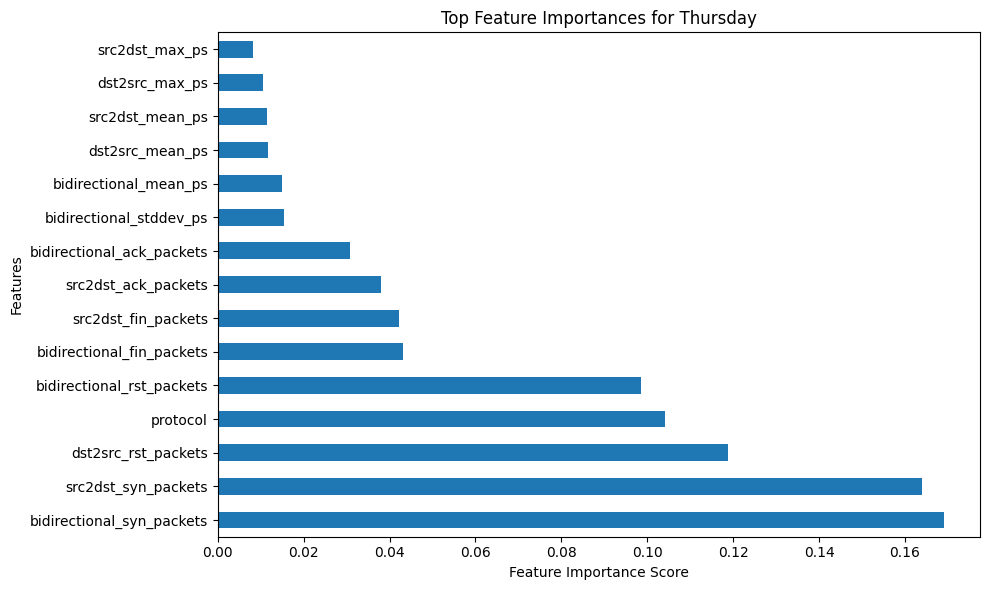

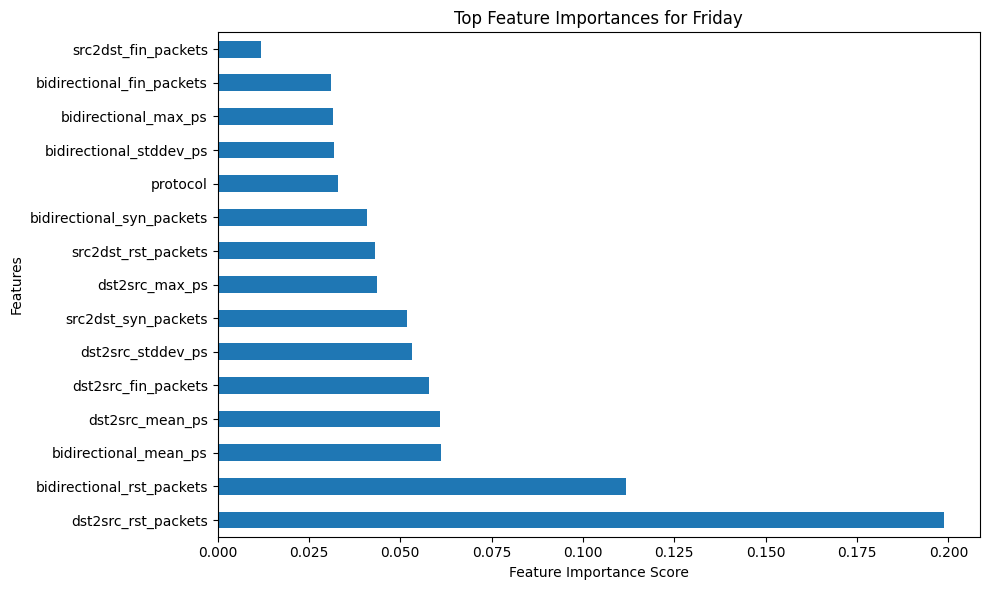

Top features for Tuesday:
['dst2src_fin_packets', 'bidirectional_stddev_ps', 'bidirectional_psh_packets', 'src2dst_psh_packets', 'src2dst_max_ps', 'bidirectional_min_ps', 'bidirectional_max_ps', 'src2dst_min_ps', 'bidirectional_mean_ps', 'src2dst_mean_ps', 'src2dst_stddev_piat_ms', 'src2dst_duration_ms', 'src2dst_stddev_ps', 'dst2src_ack_packets', 'bidirectional_bytes']

Top features for Wednesday:
['dst2src_fin_packets', 'dst2src_mean_ps', 'dst2src_stddev_ps', 'bidirectional_stddev_ps', 'bidirectional_mean_ps', 'dst2src_max_ps', 'bidirectional_fin_packets', 'bidirectional_max_ps', 'bidirectional_syn_packets', 'src2dst_fin_packets', 'dst2src_syn_packets', 'bidirectional_min_ps', 'protocol', 'src2dst_mean_ps', 'src2dst_min_ps']

Top features for Thursday:
['bidirectional_syn_packets', 'src2dst_syn_packets', 'dst2src_rst_packets', 'protocol', 'bidirectional_rst_packets', 'bidirectional_fin_packets', 'src2dst_fin_packets', 'src2dst_ack_packets', 'bidirectional_ack_packets', 'bidirectional

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import json

# GLOBAL VARIABLES
TUESDAY, WEDNESDAY, THURSDAY, FRIDAY = "Tuesday", "Wednesday", "Thursday", "Friday"
DAYS = [TUESDAY, WEDNESDAY, THURSDAY, FRIDAY]

# Define the path to the CSV files and the output directory for multi-class classification
PATH= os.path.join(MAIN_OUTPUT_DIR, CSV_DIR)
output_path = os.path.join(MAIN_OUTPUT_DIR, 'feat_sel/multi-class')

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to preprocess data and return top features
def process_data(day):
    file_path = os.path.join(PATH, f"{day}.csv")
    data = pd.read_csv(file_path)
    
    # ... [Data preprocessing steps] ...
    # data.replace([np.inf, -np.inf], np.nan, inplace=True)
    # data.dropna(inplace=True)
    # data.rename(columns={'Label': 'label'}, inplace=True)
    
    # For multi-class classification, use the 'label' column directly
    # No need for a binary label
    drop_columns = ['id', 'src_ip', 'src_mac', 'src_oui', 'dst_ip', 'dst_mac', 'dst_oui',
                    # , 'splt_direction', 'splt_ps', 'splt_piat_ms', 
                    'src_port', 'dst_port', 
                    # 'protocol',
                    'bidirectional_first_seen_ms', 'bidirectional_last_seen_ms',
                    'src2dst_first_seen_ms', 'src2dst_last_seen_ms',
                    'dst2src_first_seen_ms', 'dst2src_last_seen_ms',
                    'expiration_id', 'ip_version', 'vlan_id' 
                    # 'label'
                   ]
    data.drop(columns=drop_columns, inplace=True)
    
    X = data.drop('label', axis=1)
    y = data['label']  # This will now have multiple classes

    # Build the model
    model = ExtraTreesClassifier()
    model.fit(X, y)
    
    # Get feature importances
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    
    # Select top N features
    top_features = feat_importances.nlargest(15).index.tolist()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    feat_importances.nlargest(15).plot(kind='barh')
    plt.title(f'Top Feature Importances for {day}')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"{day}_feature_importances.png"))  # Save the figure
    plt.show()
    
    return top_features

# Dictionary to store top features for each day
top_features_per_day = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    top_features_per_day[day] = process_data(day)

# Print out the top features for each day
for day, features in top_features_per_day.items():
    print(f"Top features for {day}:\n{features}\n")

# Save the top features for each day into a JSON file
json_file_path = os.path.join(output_path, 'top_features_per_day_multi_class.json')
with open(json_file_path, 'w') as json_file:
    json.dump(top_features_per_day, json_file, indent=4)

print(f"Top features for each day have been saved to {json_file_path}")

### Classificaiton

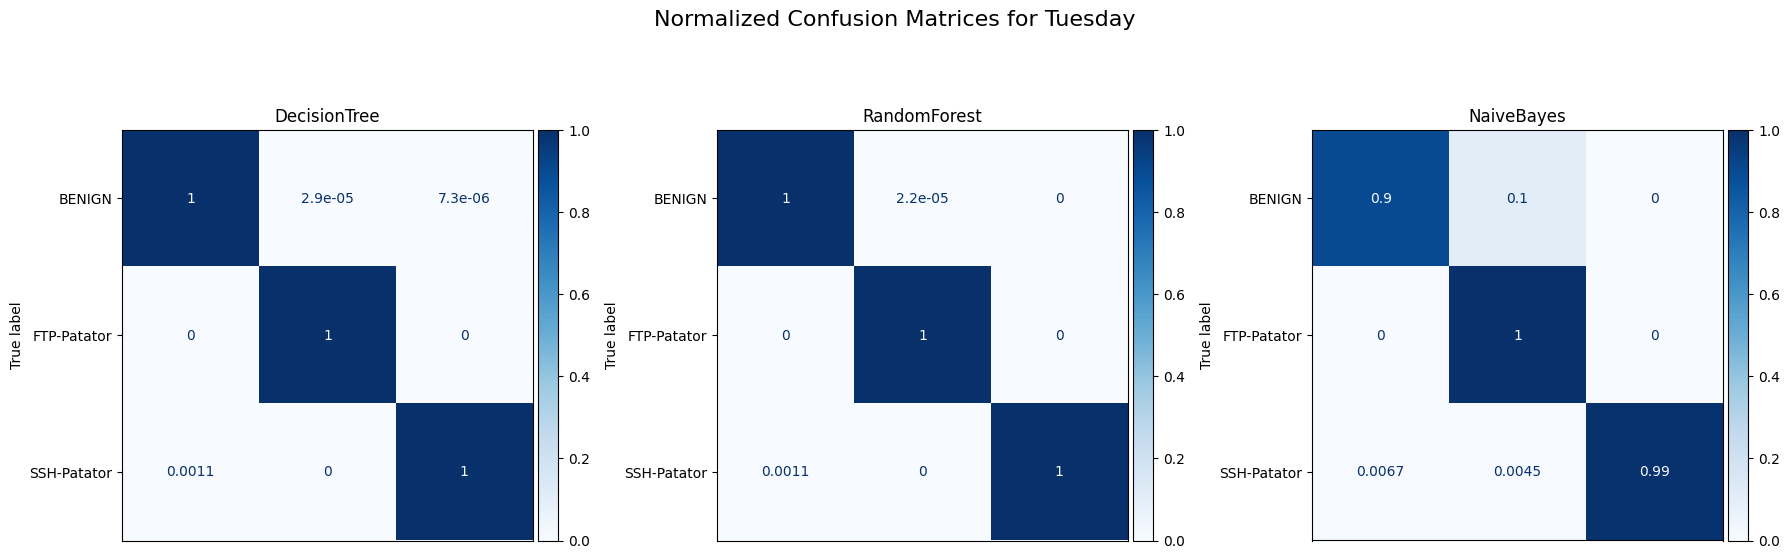

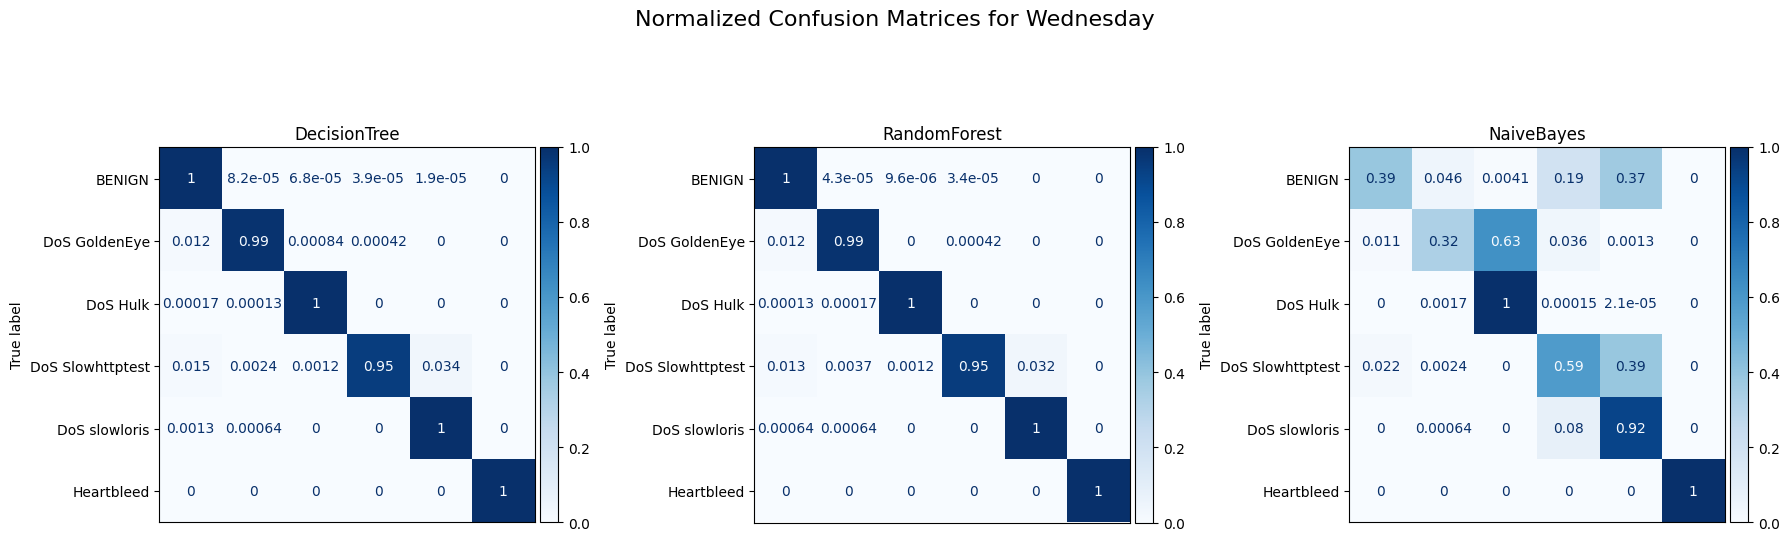

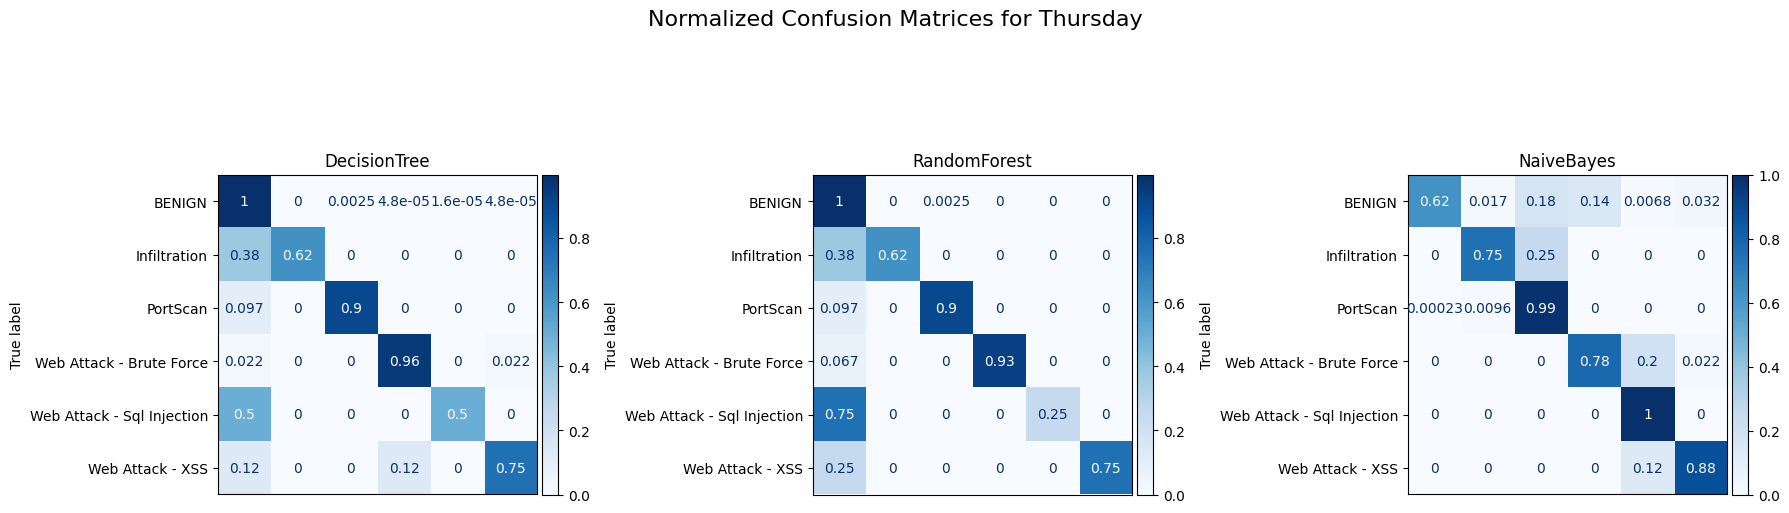

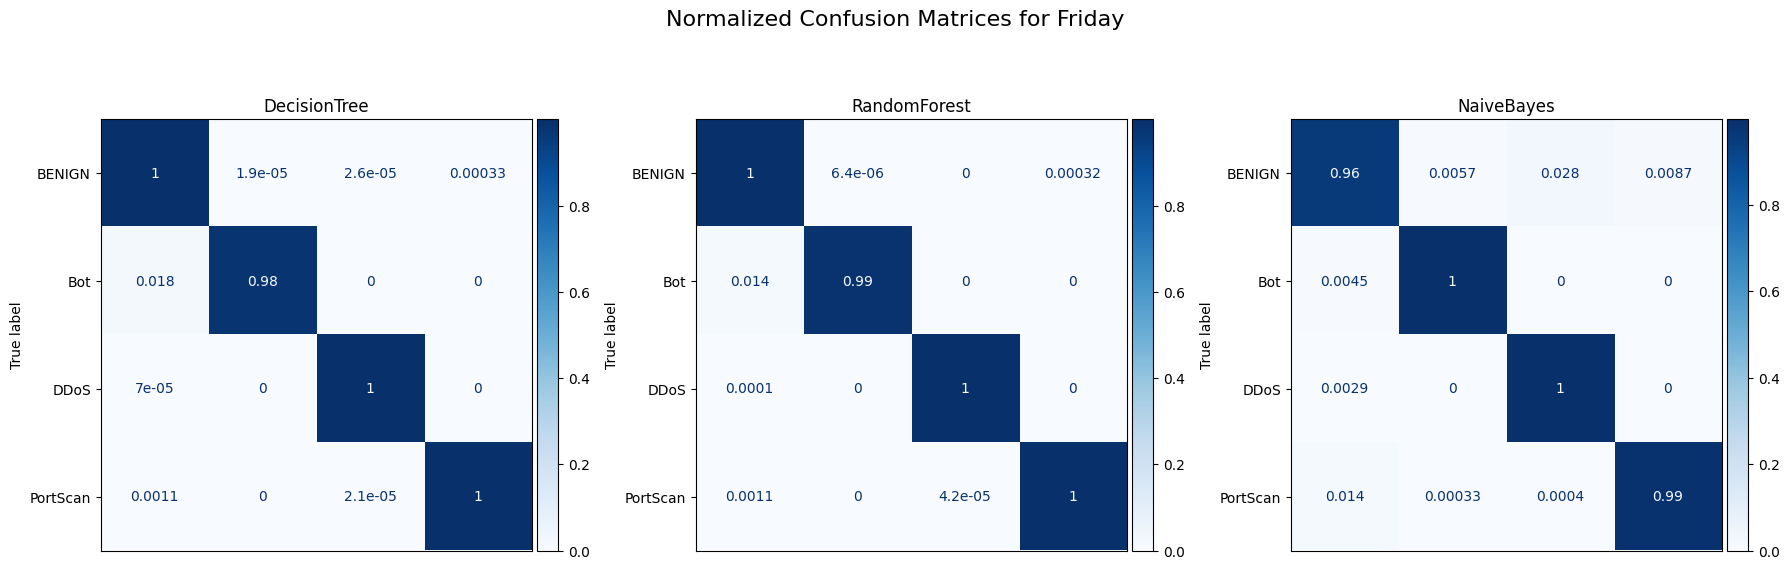

                        Precision    Recall  Accuracy  F1 Score   ROC AUC
Tuesday   DecisionTree   0.999957  0.999957  0.999957  0.999957  0.999838
          RandomForest   0.999971  0.999971  0.999971  0.999971  0.999998
          NaiveBayes     0.985369  0.898914  0.898914  0.933937  0.998703
Wednesday DecisionTree   0.999484  0.999484  0.999484  0.999482  0.999609
          RandomForest   0.999596  0.999596  0.999596  0.999594  0.999938
          NaiveBayes     0.973447  0.502993  0.502993  0.626339  0.994136
Thursday  DecisionTree   0.983512  0.983479  0.983479  0.983190  0.995042
          RandomForest   0.983567  0.983554  0.983554  0.983249  0.995329
          NaiveBayes     0.924668  0.676976  0.676976  0.750929  0.914001
Friday    DecisionTree   0.999489  0.999489  0.999489  0.999489  0.999849
          RandomForest   0.999519  0.999519  0.999519  0.999519  0.999926
          NaiveBayes     0.973774  0.968256  0.968256  0.969951  0.987969


In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_score, recall_score, accuracy_score,
                             f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the selected features for multi-class classification
# with open(json_file_path, 'r') as json_file:
#     top_features_per_day = json.load(json_file)

# Initialize a dictionary to store the metrics for each model
model_metrics = {}
confusion_matrices = {}

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    file_path = os.path.join(PATH, f"{day}.csv")
    data = pd.read_csv(file_path)
    
    # Preprocessing steps...
    # data.replace([np.inf, -np.inf], np.nan, inplace=True)
    # data.dropna(inplace=True)
    # data = data[~data["Label"].str.contains("Attempted")] # Remove rows where the "Label" column contains the string "Attempted"
    X = data[top_features_per_day[day]]
    y = data['label']  # Use original labels for multi-class classification
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Initialize classifiers
    classifiers = {
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'NaiveBayes': GaussianNB()
    }
    
    # Create a figure with subplots for each model's confusion matrix
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    fig.suptitle(f'Normalized Confusion Matrices for {day}', fontsize=16)
    
    # Train and evaluate each classifier
    for ax, (model_name, model) in zip(axes.flatten(), classifiers.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute the metrics with multi-class considerations
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')
        
        # Compute and plot the normalized confusion matrix
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
        disp.plot(cmap='Blues', ax=ax)
        ax.title.set_text(f'{model_name}')

        # Remove the original colorbar generated by ConfusionMatrixDisplay
        if disp.im_.colorbar:
            disp.im_.colorbar.remove()
        
        # Create an axis for the colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(disp.im_, cax=cax)
        
        # Remove x-axis labels and ticks
        disp.ax_.set_xlabel('')
        disp.ax_.set_xticks([])
        # Remove y-axis labels and ticks if desired
        # disp.ax_.set_ylabel('')
        # disp.ax_.set_yticks([])
        
        # Store metrics
        if day not in model_metrics:
            model_metrics[day] = {}
        model_metrics[day][model_name] = {
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        }
        
        # Store the computed confusion matrix
        confusion_matrices[(day, model_name)] = cm

        # Now create an individual figure for the current classifier
        fig_individual, ax_individual = plt.subplots(figsize=(6, 6))
        disp_individual = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
        disp_individual.plot(cmap='Blues', ax=ax_individual)
        ax_individual.title.set_text(f'{model_name} Confusion Matrix for {day}')
        # ... [code to adjust the individual plot as needed] ...

        # Remove x-axis labels and ticks
        disp_individual.ax_.set_xlabel('')
        disp_individual.ax_.set_xticks([])
        
        # Remove the original colorbar generated by ConfusionMatrixDisplay
        if disp_individual.im_.colorbar:
            disp_individual.im_.colorbar.remove()
        
        # Create an axis for the colorbar on the individual plot
        divider_individual = make_axes_locatable(ax_individual)
        cax_individual = divider_individual.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(disp_individual.im_, cax=cax_individual)
        
        # Save the individual confusion matrix plot for the current model
        fig_individual.tight_layout()
        fig_individual.savefig(os.path.join(output_path, f"{day}_{model_name}_confusion_matrix.png"))
        plt.close(fig_individual)  # Close the individual figure to free memory
    
    # Adjust layout and add a single legend
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    plt.close(fig)

# Convert the metrics dictionary to a DataFrame for better visualization
metrics_df = pd.DataFrame.from_dict({(i, j): model_metrics[i][j]
                                     for i in model_metrics.keys()
                                     for j in model_metrics[i].keys()},
                                    orient='index')

# Display the DataFrame
print(metrics_df)

# Specify the path for the JSON file where the metrics will be stored
metrics_json_path = os.path.join(output_path, 'model_performance_metrics_multi_class.json')

# Convert the DataFrame into a JSON string and save it to a file
metrics_df.to_json(metrics_json_path, orient='split', indent=4)

# Save the confusion matrices to a JSON file
cm_json_path = os.path.join(output_path, 'confusion_matrices_multi_class.json')
with open(cm_json_path, 'w') as cm_file:
    # We convert the arrays into lists for JSON serialization
    json.dump({str(k): v.tolist() for k, v in confusion_matrices.items()}, cm_file, indent=4)

# print(f"Model performance metrics and confusion matrices for multi-class classification have been saved.")

## FNN classificaiton performance


Tuesday



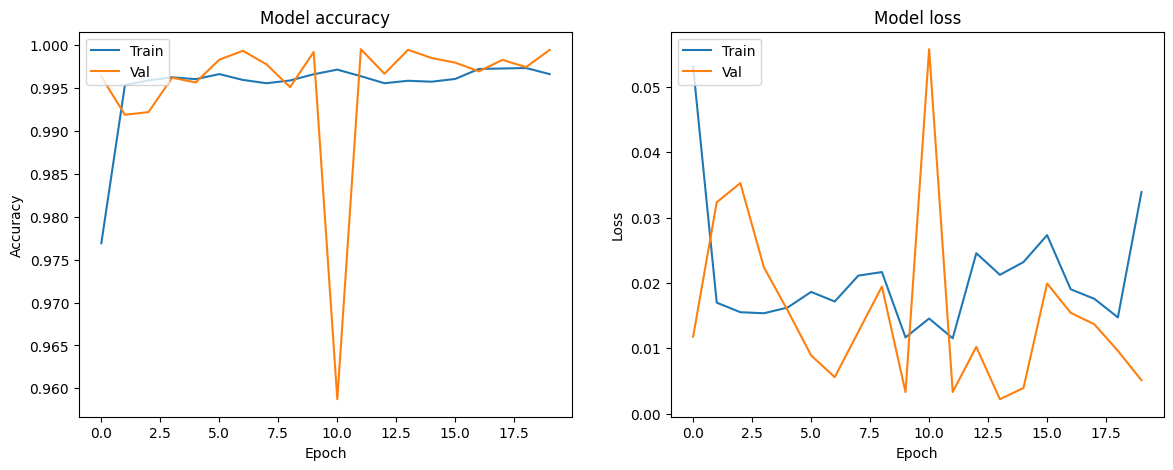

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     91262
 FTP-Patator       0.98      1.00      0.99      1593
 SSH-Patator       0.98      0.99      0.99       596

    accuracy                           1.00     93451
   macro avg       0.99      1.00      0.99     93451
weighted avg       1.00      1.00      1.00     93451



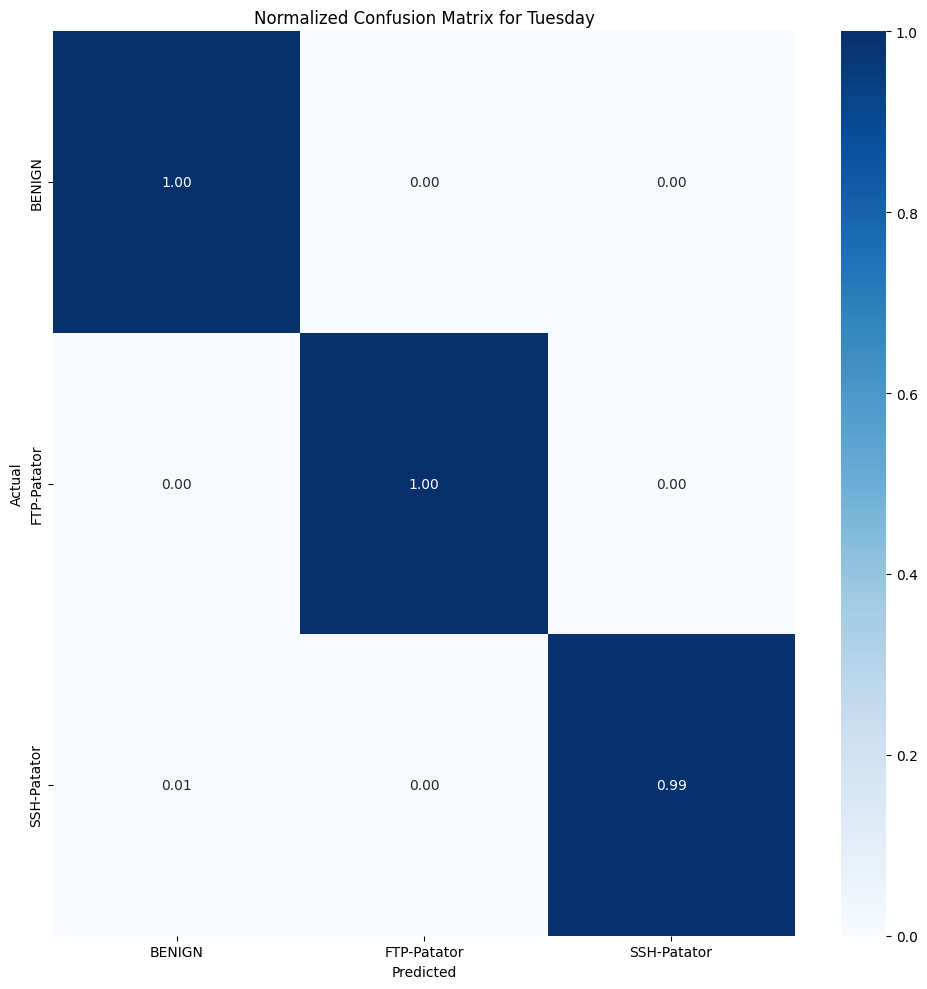


Wednesday



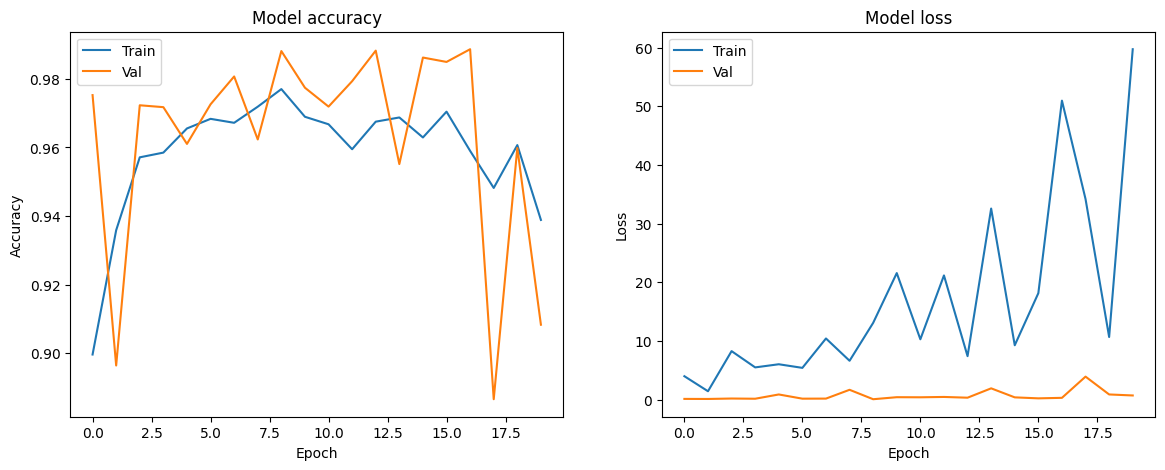

                  precision    recall  f1-score   support

          BENIGN       1.00      0.89      0.94    138203
   DoS GoldenEye       0.63      0.98      0.76      1584
        DoS Hulk       1.00      1.00      1.00     31709
DoS Slowhttptest       0.03      0.87      0.06       546
   DoS slowloris       0.67      0.96      0.79      1039
      Heartbleed       0.01      1.00      0.01         2

        accuracy                           0.91    173083
       macro avg       0.56      0.95      0.59    173083
    weighted avg       0.99      0.91      0.95    173083



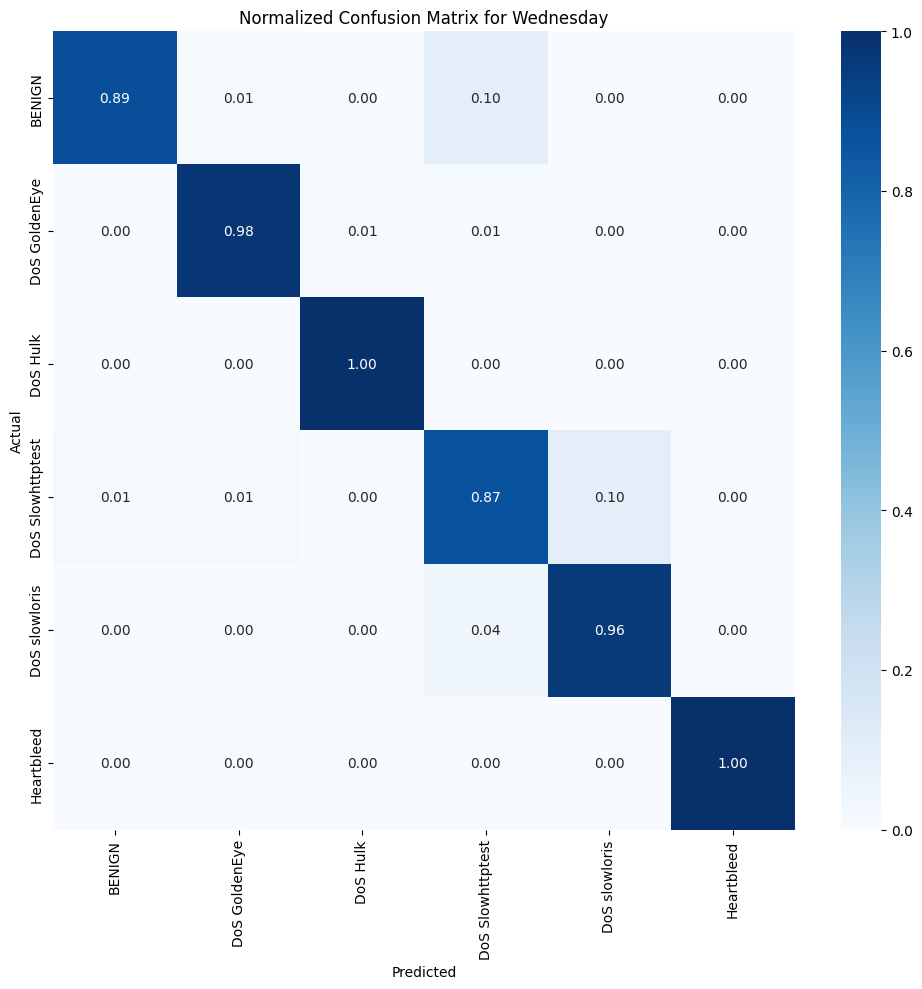


Thursday



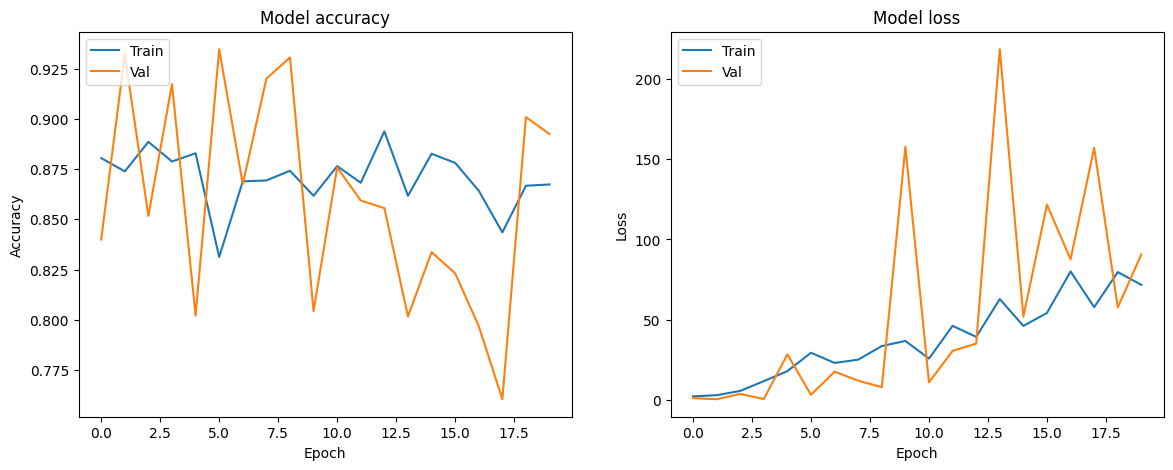

                            precision    recall  f1-score   support

                    BENIGN       0.98      0.89      0.93     82749
              Infiltration       0.00      0.67      0.00         6
                  PortScan       0.96      0.90      0.93     14253
  Web Attack - Brute Force       0.01      0.77      0.03        30
Web Attack - Sql Injection       0.00      0.50      0.00         2
          Web Attack - XSS       0.01      0.80      0.02         5

                  accuracy                           0.89     97045
                 macro avg       0.33      0.75      0.32     97045
              weighted avg       0.98      0.89      0.93     97045



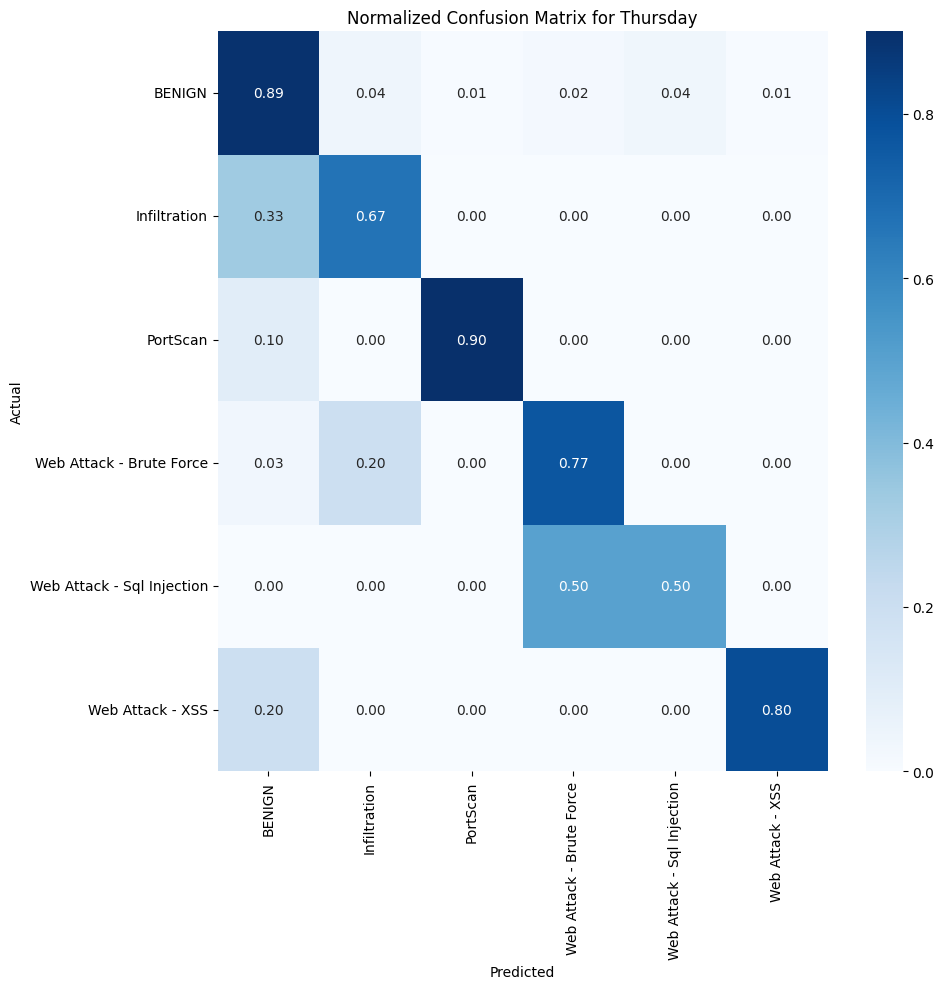


Friday



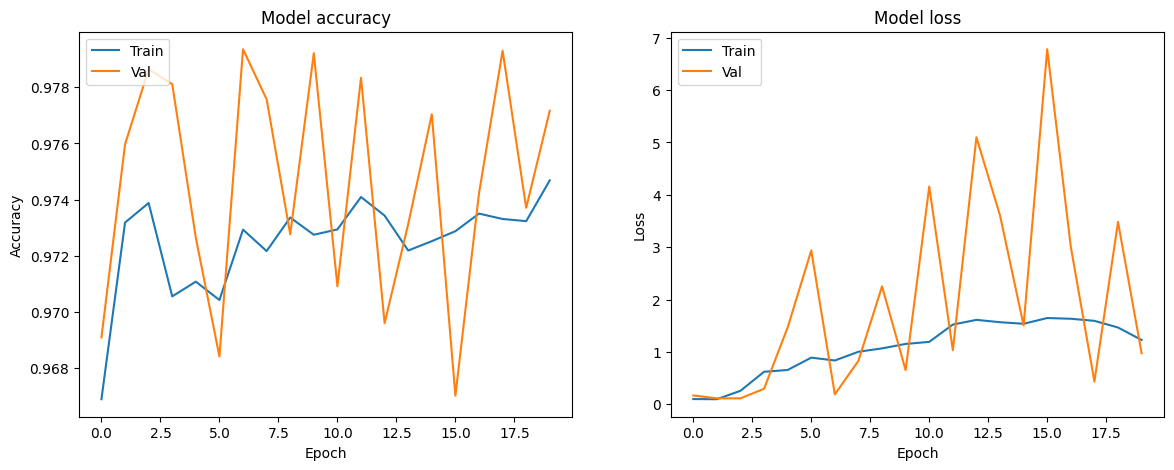

              precision    recall  f1-score   support

      BENIGN       1.00      0.97      0.98    103792
         Bot       0.06      0.99      0.10       148
        DDoS       1.00      0.99      0.99     19137
    PortScan       0.97      1.00      0.98     32062

    accuracy                           0.98    155139
   macro avg       0.76      0.99      0.77    155139
weighted avg       0.99      0.98      0.98    155139



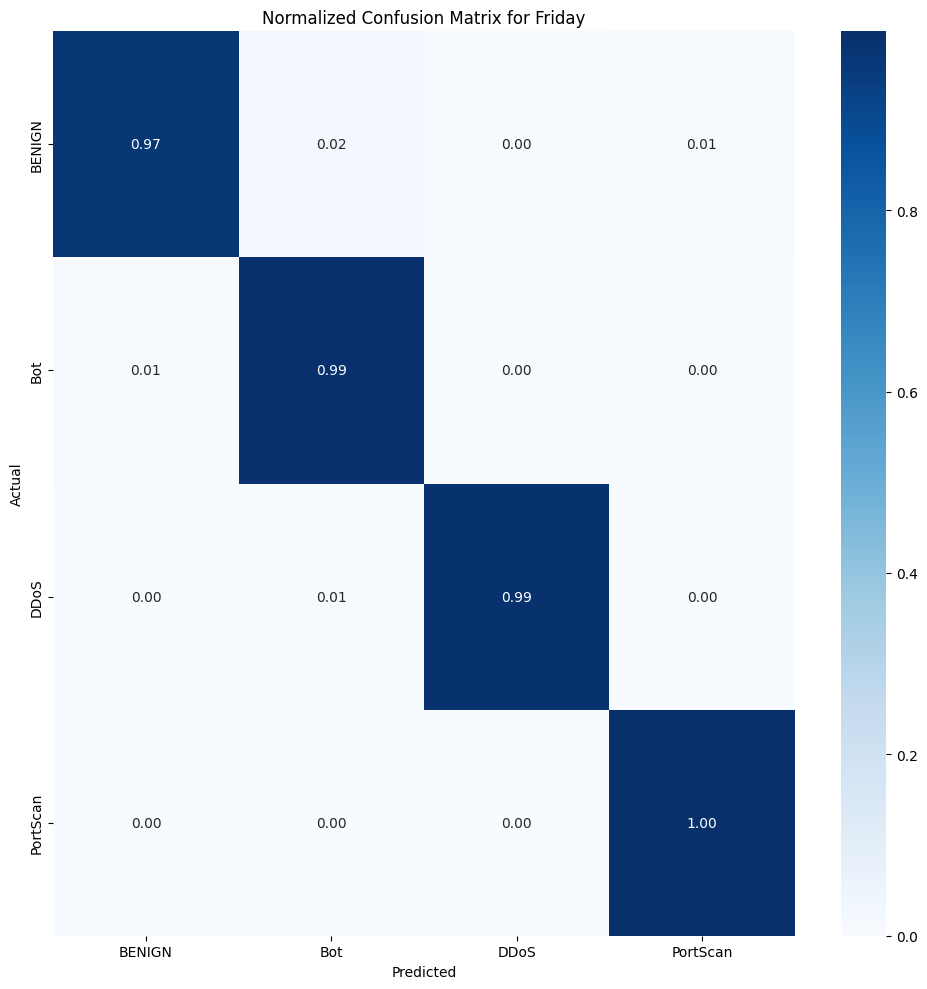

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.callbacks import Callback
import os
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

class ConfusionMatrixCallback(Callback):
    def __init__(self, X_val, y_val, label_encoder, file_path, day):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.label_encoder = label_encoder
        self.file_path = file_path
        self.day = day

    def on_epoch_end(self, epoch, logs=None):
        # Get predictions
        y_pred = self.model.predict(self.X_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Decode the one-hot encoded labels
        y_true = np.argmax(self.y_val, axis=1)
        y_true_labels = self.label_encoder.inverse_transform(y_true)

        # Decode the predicted labels
        y_pred_labels = self.label_encoder.inverse_transform(y_pred_classes)

        # Compute the confusion matrix
        cm = confusion_matrix(y_true_labels, y_pred_labels)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plot the confusion matrix
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm_normalized, annot=True, fmt=".4f",
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_, cmap='Blues')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title(f'Epoch {epoch+1}')
        plt.tight_layout()

        # Save the figure
        plt.savefig(os.path.join(self.file_path, f'{self.day}-cm-{epoch+1}.png'))
        plt.close()

# Directory for confusion matrices
cm_directory = os.path.join(output_path, "nn-confusion_matrices")
os.makedirs(cm_directory, exist_ok=True)

# Iterate over each day and process the corresponding CSV file
for day in DAYS:
    print(f"\n{day}\n")
    file_path = os.path.join(PATH, f"{day}.csv")
    data = pd.read_csv(file_path)

    # Feature matrix and labels
    X = data[top_features_per_day[day]]
    y = data['label']
    
    # Encode labels to numeric
    label_encoder = LabelEncoder()
    y_numeric = label_encoder.fit_transform(y)
    
    # Compute class weights
    classes = np.unique(y_numeric)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_numeric)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    # Split the dataset (stratify with numeric labels)
    X_train, X_val, y_train_numeric, y_val_numeric = train_test_split(
        X, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
    )
    
    # One-hot encode the numeric labels
    y_train = to_categorical(y_train_numeric)
    y_val = to_categorical(y_val_numeric)
    
    # Initialize and fit scaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Neural network model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Callback instance using the scaled validation data and one-hot encoded labels
    cm_callback = ConfusionMatrixCallback(X_val_scaled, y_val, label_encoder, cm_directory, day)
    
    # Train model with class weights and callback
    history = model.fit(
        X_train_scaled, y_train,
        epochs=20,
        validation_data=(X_val_scaled, y_val),
        class_weight=class_weight_dict,
        callbacks=[cm_callback],
        verbose=0
    )
    
    # Plot the training history
    plt.figure(figsize=(14, 5))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    
    plt.show()
    
    # Predict the values from the validation dataset using the scaled validation data
    y_pred = model.predict(X_val_scaled, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Decode the one-hot encoded true labels to compare with predictions
    y_true = np.argmax(y_val, axis=1)
    
    # Use label_encoder to transform the predictions back to original labels
    y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
    y_true_labels = label_encoder.inverse_transform(y_true)
    
    # Classification report using the original labels
    print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))
    
    # Confusion matrix using the decoded labels
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting the normalized confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_, 
                cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Normalized Confusion Matrix for {day}')
    plt.tight_layout()
    plt.show()

## Transform per epoch performances into a GIF

In [6]:
import imageio.v2 as imageio
import os
import glob

# Iterate over each day to create GIFs and delete PNGs
for day in DAYS:
    gif_path = os.path.join(cm_directory, f'{day}_confusion_matrices.gif')
    # Get all PNG files for the current day
    png_files = sorted(glob.glob(os.path.join(cm_directory, f'{day}-cm-*.png')), key=os.path.getmtime)
    # Create a GIF from the PNG files
    with imageio.get_writer(gif_path, mode='I', fps=1) as writer:
        for png_file in png_files:
            image = imageio.imread(png_file)
            writer.append_data(image)
    # Delete the PNG files
    for png_file in png_files:
        os.remove(png_file)